## Reading-in data

First we import the required packages and modules. The last line imports the utility scoring function from the file that was published in Challenge's GitHub page. 

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import TensorSpec as ts
import pandas as pd
from scipy.special import logit
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from matplotlib import pyplot as plt 
from tqdm import tqdm, trange
from time import time
from evaluate_sepsis_score import compute_prediction_utility


We set up some constants that govern how many CV folds we assume and which CV fold is used for testing, as well as number of batches for mini-batch model fitting.

In [2]:
startTime = time()
dataDir = r"E:\AALTO\Kevät2020\STATISTICAL GENETICS  & PERS. MED\Project\data"
dtype = np.double
reloadDataFlag = False
cvFoldN, cvFold = 5, 0
batchN = 10

Next we import the data from the raw data files, do some truncation for the very outlying outcomes and save the preprocessed data to a single file that is much faster to load.

In [3]:
wspace = 0.5  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.55  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
if reloadDataFlag:
  subDirList = ["training_setA", "training_setB"]
  dataFrames, P = [], 0
  for subDir in subDirList:
    files = [f for f in os.listdir(os.path.join(dataDir,subDir)) if os.path.isfile(os.path.join(dataDir,subDir, f))]
    for f in tqdm(files):
      df = pd.read_csv(os.path.join(dataDir,subDir,f),sep="|")
      df["Id"] = P
      dataFrames.append(df)
      P += 1
  dataFrame = pd.concat(dataFrames)
      
  fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20,9))
  for i,ax in enumerate(axes.flatten()):
    q = np.nanquantile(dataFrame.iloc[:,i],[0,0.001,0.01,0.05,0.25,0.5,0.75,0.95,0.99,0.999,1])
    dataFrame.iloc[:,i] = np.clip(dataFrame.iloc[:,i], q[1],q[-2])
    ax.hist(dataFrame.iloc[:,i], bins=10, fc=(0, 1, 0, 1))
    ax.set_title(str(i) + " " + dataFrame.columns[i])
      
      
  plt.subplots_adjust(wspace=wspace, hspace=hspace)
  plt.show()
  
  dataFrame.to_pickle(os.path.join(dataDir,"all_raw_data.pkl"))
else:
  dataFrame = pd.read_pickle(os.path.join(dataDir,"all_raw_data.pkl"))
  P = np.unique(dataFrame["Id"]).shape[0]

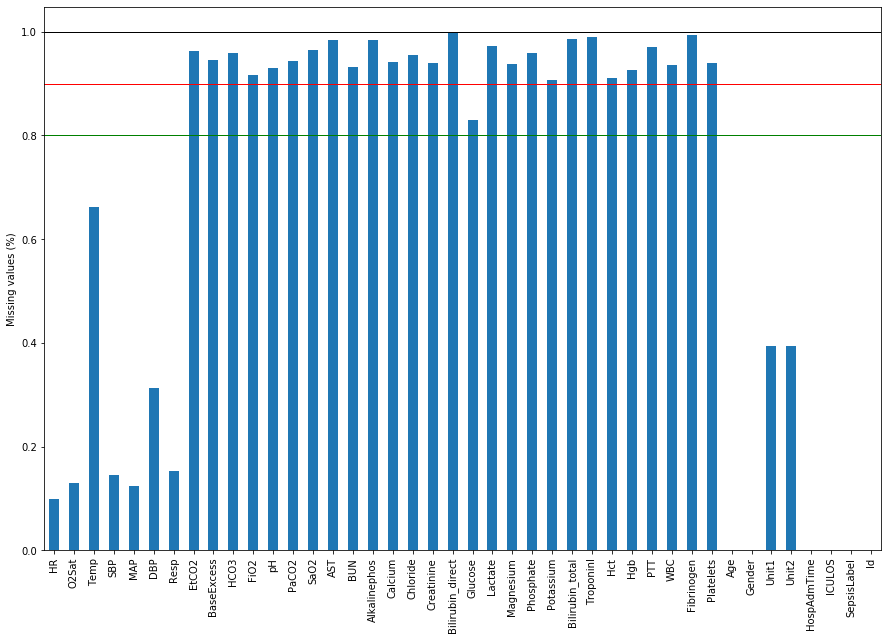

In [4]:
# Calculate the percentage of missing values per feature and plot them

Nan_frame = dataFrame.isna().sum()
N = dataFrame.shape[0]
Nan_frame = Nan_frame/N

ax = Nan_frame.plot.bar(figsize=(15,10))
plt.axhline(y=.8,linewidth=1, color='g')
plt.axhline(y=.9,linewidth=1, color='r')
plt.axhline(y=1,linewidth=1, color='k')
plt.ylabel("Missing values (%)")
path = r"E:\AALTO\Kevät2020\STATISTICAL GENETICS  & PERS. MED\Project\Statistical-Genetics-and-Personalised-Medicine-Assignment\Graphs\missing_values.png"
plt.savefig(path)

Throw away the values that are missing more than 20% and visualize the data. Impute the rest missing values as means of the patient

In [5]:
# DATA IMPUTATION time~2,5h
    # Does not impute patients with all values nan 
    # -> later replaced with 0
    
Nan_frame = Nan_frame[Nan_frame<0.80]
stripped_frame = dataFrame[Nan_frame.index]

# Join the units as one
stripped_frame["Unit"] = stripped_frame["Unit1"] + 2*stripped_frame["Unit2"] - 1 
stripped_frame.loc[np.isnan(stripped_frame["Unit"]),"Unit"] = 2

stripped_frame=stripped_frame.drop(['Unit1','Unit2'], axis=1)

print(stripped_frame.columns)
print(stripped_frame.shape)

# Impute all nan values of a patient with the mean 
for p in trange(P):
    ROI = stripped_frame[stripped_frame["Id"]==p]
    ROI = ROI.fillna(ROI.mean())
    stripped_frame[stripped_frame["Id"]==p] = ROI

stripped_frame.to_pickle(os.path.join(dataDir,"stripped_filled_data.pkl"))
print("Imputation complete...")

C:\Users\makke\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\makke\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
  0%|                                                                                        | 0/40336 [00:00<?, ?it/s]

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Id', 'Unit'],
      dtype='object')
(1552210, 14)


  1%|█▏                                                                          | 605/40336 [02:10<2:23:02,  4.63it/s]


KeyboardInterrupt: 

In [5]:
# START HERE IF THE DATA HAS BEEN ALREADY RESHAPED
# Divide tha training and testing data

f_s_df = pd.read_pickle(os.path.join(dataDir,"stripped_filled_data.pkl"))

# Delete existing nans (Some patients did not have values at all)
    # Let's see how the network perform with just zerovalues
#to_delete = f_s_df[f_s_df['Id'].isnull()]
#print(to_delete.Id.unique().shape)

data = f_s_df.to_numpy()

# Divide the data to train and test set with both good amount of sepsis patients
all_patients = np.arange(P)

# Check which patients get sepsis at some point
target_rows =  data[data[:,-3]==1]
id_sepsis_patients = np.unique(target_rows[:,-2])

# The training/testing ratio for sepsis patients 
test_amount_sep = np.rint(0.20*id_sepsis_patients.shape[0])
sepsis_test = np.random.choice(id_sepsis_patients, test_amount_sep.astype(int),replace=False)
sepsis_train = np.setdiff1d(id_sepsis_patients, sepsis_test)

# The trainin/testing ratio for nor sepsis patients
not_sepsis_patients = np.setdiff1d(all_patients, id_sepsis_patients)
test_amount_notsep = np.rint(0.20*not_sepsis_patients.shape[0])
not_sepsis_test = np.random.choice(not_sepsis_patients, test_amount_notsep.astype(int),replace=False)
not_sepsis_train = np.setdiff1d(not_sepsis_patients, not_sepsis_test)

patient_Test = np.concatenate((not_sepsis_test,sepsis_test))
patient_Train = np.setdiff1d(all_patients, patient_Test)

print("The amount of patients who get sepsis: ",id_sepsis_patients.shape[0])
print("The amount of patients who dont get sepsis: ", not_sepsis_patients.shape[0])
print("All patients: ",all_patients.shape[0])
print("Train set: ", patient_Train.shape[0])
print("Test set: ", patient_Test.shape[0])

print("_______")
print("The amount of sepsis patients choosed in test set: ",sepsis_test.shape[0])
print("The amount of sepsis patients choosed in train set",sepsis_train.shape[0])
print("The amount of healthy patients choosed in test set",not_sepsis_test.shape[0])
print("The amount of healthy patients choosed in train set", not_sepsis_train.shape[0])



# Make masks to get the training and testing sets
indTrain = np.isin(data[:,-2], patient_Train)
indTest = np.isin(data[:,-2], patient_Test)
data_Train = data[indTrain]
data_Test = data[indTest]


# Get the X and y for train and test
    # Y = sepsis labels and X = data without sepsis labels
    # REMEMBER NOT TO INPUT ID TO NETWORK!!!
    # ID = -2, Sepsislabel= -1 
perm = [0,1,2,3,4,5,6,7,8,9,10,13,12,11]
X_train = data_Train[:,perm]
X_test = data_Test[:,perm]

# Scale (normalize) X_train 
    # XScale = [2,12]
XScale = np.array([np.nanmean(X_train[:,:-2],0),np.nanstd(X_train[:,:-2],0)])
XScale[:,-1] = [0,1]
XScale[0,0] = 0

X_train_scaled = X_train
X_train_scaled[:,:-2] = (X_train_scaled[:,:-2] - XScale[0]) / XScale[1]
X_test_scaled = X_test
X_test_scaled[:,:-2] = (X_test_scaled[:,:-2] - XScale[0]) / XScale[1]

Data_Train = X_train_scaled
Data_Test = X_test_scaled



The amount of patients who get sepsis:  2932
The amount of patients who dont get sepsis:  37404
All patients:  40336
Train set:  32269
Test set:  8067
_______
The amount of sepsis patients choosed in test set:  586
The amount of sepsis patients choosed in train set 2346
The amount of healthy patients choosed in test set 7481
The amount of healthy patients choosed in train set 29923


In [6]:
# The paramters for the model
epochs = 2
time_steps = 8
# -2 as ID is not feature and sepsis label has already been removed
n_features = X_train.shape[1]-2
early_stop = 0.05 

In [7]:
# Function to reshape the data for the network
def split_sequences(sequences,n_steps):
    """
    Input:  Sequences = the data of one patient
            n_steps = the screening window size 
    
    returns X and y in the form of 
    X:(m_batch,time_step,num_features)
    Y:(m_batch,time_step,1)
    """
    # Delete the patient id 
    sequences = np.delete(sequences, -2, axis=1) 
    
    X,y=list(),list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[i:end_ix, -1]
        X.append(seq_x)
        y.append(seq_y.reshape(-1,1))
        
    return np.array(X), np.array(y)

In [9]:
# The LSTM-model in KERAS
LSTM_model = tf.keras.Sequential()

LSTM_model.add(tf.keras.layers.LSTM(units=100,input_shape=(time_steps,n_features),return_sequences=True))
LSTM_model.add(tf.keras.layers.Dropout(0.2))

LSTM_model.add(tf.keras.layers.LSTM(units=100,return_sequences=True))
LSTM_model.add(tf.keras.layers.Dropout(0.2))

LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(25,activation='relu')))
LSTM_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='sigmoid')))

adam = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.)
LSTM_model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])


In [109]:
## Reshape train datasets to usable form time~2h
for idx,p in enumerate(tqdm(patient_Train)):
    p_sequence = Data_Train[Data_Train[:,-2]== p]
    x,y = split_sequences(p_sequence,time_steps) 
    
    if idx == 0:
        Input_train = x
        Label_train = y
    else:
        Input_train = np.concatenate((Input_train,x), 0)
        Label_train = np.concatenate((Label_train,y), 0)
       
print("Iterated through patients: ", idx)
np.save(dataDir+"\input_train.npy",Input_train)
np.save(dataDir+"\label_train.npy",Label_train)
    


100%|██████████████████████████████████████████████████████████████████████████| 32269/32269 [1:56:02<00:00,  4.63it/s]


Iterated through patients:  32268


In [149]:
## Reshape test datasets to usable form time~10min
for idx,p in enumerate(tqdm(patient_Test)):
    p_sequence = Data_Test[Data_Test[:,-2]== p]
    x,y = split_sequences(p_sequence,time_steps) 
    if idx == 0:
        Input_test = x
        Label_test = y
    else:
        Input_test = np.concatenate((Input_test,x), 0)
        Label_test = np.concatenate((Label_test,y),0)
    
print("Iterated through patients: ", idx+1)
np.save(dataDir+"\input_test.npy",Input_test)
np.save(dataDir+"\label_test.npy",Label_test)


 13%|█████████▊                                                                   | 1030/8067 [00:07<00:52, 133.33it/s]


KeyboardInterrupt: 

In [10]:
# The train loop for the LMST- model
Input_train = np.load(dataDir+"\input_train.npy") 
Label_train = np.load(dataDir+"\label_train.npy") 
Input_test = np.load(dataDir+"\input_test.npy") 
Label_test = np.load(dataDir+"\label_test.npy") 

# Lets see how the model performs if we change all nans to 0
Input_train_non =np.nan_to_num(Input_train) 
Input_test_non = np.nan_to_num(Input_test)

# Fit the model using training data
history = LSTM_model.fit(Input_train_non, Label_train, batch_size=128, epochs=epochs)
print("Model trained...")

# Evaluate the model using test data
results = LSTM_model.evaluate(Input_test_non, Label_test, batch_size=128)
print('test loss, test acc:', results)

LSTM_model.save_weights(dataDir+"\model_weights")


Train on 1013376 samples
Epoch 1/2
1013376/1013376 [==============================] - 156s 154us/sample - loss: 0.0126 - accuracy: 0.9876
Epoch 2/2
1013376/1013376 [==============================] - 152s 150us/sample - loss: 0.0119 - accuracy: 0.9876
Model trained...
256482/256482 [==============================] - 16s 63us/sample - loss: 0.0122 - accuracy: 0.9877
test loss, test acc: [0.012179880707917827, 0.98766285]


In [69]:
# Create the prediction matrix 
    # Loop through the patients and predict separately for each patient

    # Sum time window probabilities and find first value that is over 2.4 (change it later)
    
    
pred = []
observed_utilities = np.zeros([patient_Test.shape[0]])

for idx,p in enumerate(tqdm(patient_Test)):
    p_sequence = np.nan_to_num(Data_Test[Data_Test[:,-2]== p])

    sep_label = p_sequence[:,-1]
    
    x,y = split_sequences(p_sequence,time_steps) 
    
    p_predictions = LSTM_model.predict(x)
    
    p_pred_sum = (np.sum(p_predictions,axis=1))
                
    # Might still exist local minimums that stay false
    pred_mask = p_pred_sum > 2
    
    # Difference in length
    diff = p_sequence.shape[0] - pred_mask.shape[0] 
                  
    # Pad the prediction with the edge value
    pred_mask = np.pad(pred_mask, ((0,diff),(0,0)), 'edge')
                  
    pred.append(pred_mask)
    
    observed_utilities[idx],_ = compute_prediction_utility(sep_label, pred_mask)
    
#print(len(pred))
#print(pred_mask.shape)
#print(p_sequence.shape)
#print(pred_mask)
#print(p_sequence)
print(observed_utilities.shape)
  

100%|██████████████████████████████████████████████████████████████████████████████| 8067/8067 [04:11<00:00, 32.04it/s]

(8067,)


Following the scoring rules of the Challenge, we compute the utility of trivial (inaction) predictions and optimal predictions. Those are used to get a score that shall be within the range $[0,1]$.

In [67]:
dt_early   = -12
dt_optimal = -6
dt_late    = 3

testN = patient_Test.shape[0]
best_utilities     = np.zeros(testN)
inaction_utilities = np.zeros(testN)


#with tqdm(range(testN)) as progressBar:
  #for indTest in progressBar:
    
for idx,p in enumerate(tqdm(patient_Test)):
    patient_sequence = np.nan_to_num(Data_Test[Data_Test[:,-2]== p])
    sep_label_vec = patient_sequence[:,-1]
    
    #idTest = idVecTest[indTest]

    #indIdTest = np.where(XTest[:,-1] == idTest)[0]

    #XTestId,YTestId = XTest[indIdTest,:-1].copy(), YTest[indIdTest].copy()

    #sepLabelVec = ~np.isnan(XTestId[:,0]) * (XTestId[:,0]>=0.0)
    
    N = patient_sequence.shape[0]
    best_predictions     = np.zeros(N)
    inaction_predictions = np.zeros(N)
    action_predictions = np.ones(N)
    if np.any(sep_label_vec):
      # Optimal prediction time is the period of 6 hours after first 1 in sepsilabel  
      t_sepsis = np.argmax(sep_label_vec) - dt_optimal
      # The best prediction times for the patient
      best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, N)] = 1
    # Save the best utilities for do-something and do-nothing (?)
    best_utilities[idx],_ = compute_prediction_utility(sep_label_vec, best_predictions)
    inaction_utilities[idx],_ = compute_prediction_utility(sep_label_vec, inaction_predictions)
unnormalized_best_utility     = np.sum(best_utilities)
unnormalized_inaction_utility = np.sum(inaction_utilities)

100%|█████████████████████████████████████████████████████████████████████████████| 8067/8067 [00:09<00:00, 828.41it/s]


Finally, we print the predictive score for the current CV fold.

In [70]:
unnormalized_observed_utility = np.sum(observed_utilities)
normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)
print("\nPredictive utility score %.3f, elapsed time %ds"%(normalized_observed_utility, time() - startTime))


Predictive utility score 0.017, elapsed time 9826s


This example with linear model ends up in somewhat $0.03$ utility score if we average over the 5 CV folds. This is very far behind the methods from the top of the leaderboard, but still better than the best trivial predictions. However, this is why this model is marked as number 1, so the other onces shall generally perform better. Also, remember that you are not requested to beat them, but rahter conducting a course project that is aimed to give you practical skills on multivariate generative modelling that would be applicable in a wide range of biomedical applications.



## NOTES

The predictions have ~8hour window of no predictions in the end of each patient. -> how to deal with that? 
    - Pad the last prediction value to the end. The network should be able to classify right the last label at least

Predictive utility 0.009, 0.017


# Enjoy the exciting dataset and good luck!